<a href="https://colab.research.google.com/github/yjkim721/STRIP-ViTA/blob/main/SC_2DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SC Preprocessing
We first convert the audio signal into 2D spectrogram and then employ the
2D CNN for speech command recognition task.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
clean_dataset_path = '/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/SC_melspectrogram_clear.hdf5'
trojan_dataset_path = '/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/SC_melspectrogram_trojan.hdf5'
clean_sound_dataset_path = '/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/SC_sound_clear.hdf5'
trojan_sound_dataset_path = '/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/SC_sound_trojan.hdf5'
output_path = '/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/output/SC_2DCNN.pdf'

## Load Data: x_train, y_train, x_test, y_test

- for h5py v1.0, use *df\['x_train'].value*
- for h5py v2.0, use *df.get('x_train')\[...]*

In [3]:
import h5py
clean_df = h5py.File(clean_dataset_path, 'r')
trojan_df = h5py.File(trojan_dataset_path, 'r')

x_train = clean_df.get('x_train')[...]
y_train = clean_df.get('y_train')[...]
x_test = clean_df.get('x_test')[...]
y_test = clean_df.get('y_test')[...]

trojan_x_train = trojan_df.get('x_train')[...]
trojan_x_test = trojan_df.get('x_test')[...]

In [4]:
clean_df = h5py.File(clean_sound_dataset_path, 'r')
trojan_df = h5py.File(trojan_sound_dataset_path, 'r')

x_train_sound = clean_df.get('x_train')[...]
y_train_sound = clean_df.get('y_train')[...]
x_test_sound = clean_df.get('x_test')[...]
y_test_sound = clean_df.get('y_test')[...]

trojan_x_train_sound = trojan_df.get('x_train')[...]
trojan_x_test_sound = trojan_df.get('x_test')[...]

## Poison inputs
We randomly generate a noise sound and treat it as trigger.
We poisoned 1000 (4.8%) out of 20,827 training samples.


In [5]:
# poison if needed
# If you want to make a clear model, do not run this code
for i in range(1000):
  x_train[i] = trojan_x_train[i]
  y_train[i] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

trojan_y_test = clean_df.get('y_test')[...]
for i in range(trojan_y_test.shape[0]):
  trojan_y_test[i] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [6]:
x_train = x_train.reshape(-1, 128, 33, 1)
x_test = x_test.reshape(-1, 128, 33, 1)
trojan_x_test = trojan_x_test.reshape(-1, 128, 33, 1)

# Define model

In [7]:
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 33, 32)       320       
_________________________________________________________________
activation (Activation)      (None, 128, 33, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 33, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 33, 32)       9248      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 33, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 33, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 16, 32)        0

## Train

In [8]:
# define callback list
from keras.callbacks import *
callback_list = [
    EarlyStopping(
        patience=3,
        monitor='val_acc',
    ),
    ReduceLROnPlateau(
        patience=1,
        factor=0.5,
    )
]

opt_rms = keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = model.fit(x_train, y_train, callbacks=callback_list, batch_size=16, epochs=100,
                    validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
1184/1184 [==============================] - 48s 12ms/step - loss: 2.8201 - accuracy: 0.5520 - val_loss: 2.1536 - val_accuracy: 0.7036
Epoch 2/100
1184/1184 [==============================] - 13s 11ms/step - loss: 0.7970 - accuracy: 0.8546 - val_loss: 0.7824 - val_accuracy: 0.8492
Epoch 3/100
1184/1184 [==============================] - 13s 11ms/step - loss: 0.5450 - accuracy: 0.9051 - val_loss: 0.4483 - val_accuracy: 0.9250
Epoch 4/100
1184/1184 [==============================] - 14s 11ms/step - loss: 0.3836 - accuracy: 0.9298 - val_loss: 0.5256 - val_accuracy: 0.9026
Epoch 5/100
1184/1184 [==============================] - 13s 11ms/step - loss: 0.2627 - accuracy: 0.9589 - val_loss: 0.3735 - val_accuracy: 0.9398
Epoch 6/100
1184/1184 [==============================] - 13s 11ms/step - loss: 0.2173 - accuracy: 0.9659 - val_loss: 0.3341 - val_accuracy: 0.9563
Epoch 7/100
1184/1184 [==============================] - 13s 11ms/step - loss: 0.2000 - accuracy: 0.9678 - val_loss: 0

# Performance: accuracy

In [9]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

37/37 [==============================] - 2s 43ms/step - loss: 0.2177 - accuracy: 0.9687

Test result: 96.874 loss: 0.218


# Performance: Test attack success *rate*

In [10]:
scores = model.evaluate(trojan_x_test, trojan_y_test, verbose=1)
print('Trojaned Model Test Attack success rate:', scores[1]*100)

148/148 [==============================] - 1s 8ms/step - loss: 0.0707 - accuracy: 0.9954
Trojaned Model Test Attack success rate: 99.53527450561523


# Superimpose

In [11]:
import cv2
import librosa

def superimpose(background, overlay):
  overlayed = background + overlay
  s = librosa.feature.melspectrogram(overlayed, 16000)
  s1 = librosa.power_to_db(s, ref=np.max)
  x = np.zeros((128, 33), dtype=float)
  for i in range(s1.shape[0]):
    for j in range(s1[i].size):
      x[i][j] = s1[i][j]

  res = x.reshape(128, 33, 1)
  return res

In [12]:
import numpy as np
np.random.seed(12345678)

def entropyCal(background_idx, n, trojan):
  x1_add = [0] * n
  
  # choose n overlay indexes between 10000 and 18000
  index_overlay = np.random.randint(10000, 18000, n)

  # do superimpose n times
  if trojan:
    background_arr = trojan_x_train_sound
  else:
    background_arr = x_train_sound

  for i in range(n):
    x1_add[i] = superimpose(background_arr[background_idx], x_train_sound[index_overlay[i]])

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

In [13]:
from tqdm import tqdm

#idx: 5000 ~ 7000: trojan
#idx: 7000 ~ 9000: benign
#idx: 10000 ~ 18000: overlapped images

n_test = 2000
n_sample = 100
entropy_bb = [0] * n_test # entropy for benign + benign

for j in tqdm(range(n_test), desc="Entropy:benign_benign"):
  x_background_idx = j+7000
  entropy_bb[j] = entropyCal(x_background_idx, n_sample, False)

Entropy:benign_benign:  79%|███████▉  | 1582/2000 [29:12<07:50,  1.13s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
Entropy:benign_benign: 100%|██████████| 2000/2000 [36:54<00:00,  1.11s/it]


In [14]:
entropy_tb = [0] * n_test # entropy for trojan + benign
  
for j in tqdm(range(n_test), desc="Entropy:trojan_benign"):
  entropy_tb[j] = entropyCal(j+5000, n_sample, True)

Entropy:trojan_benign:   0%|          | 7/2000 [00:07<36:08,  1.09s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
Entropy:trojan_benign: 100%|██████████| 2000/2000 [36:57<00:00,  1.11s/it]


In [15]:
final_entropy_bb = [x / n_sample for x in entropy_bb]
final_entropy_tb = [x / n_sample for x in entropy_tb]

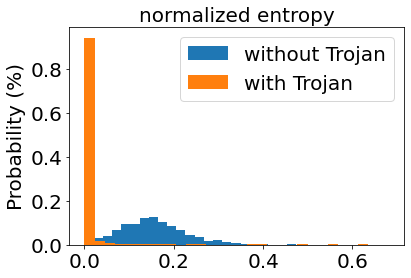

In [16]:
import matplotlib.pyplot as plt
bins = 30

plt.hist(final_entropy_bb, bins, weights=np.ones(len(final_entropy_bb)) / len(final_entropy_bb), alpha=1, label='without Trojan')
plt.hist(final_entropy_tb, bins, weights=np.ones(len(final_entropy_tb)) / len(final_entropy_tb), alpha=1, label='with Trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
fig1.savefig(output_path)# save the fig as pdf file

In [17]:
# max entropy of trojaned inputs < min entropy of clean inputs
print("benign+benign: ", min(final_entropy_bb),"~", max(final_entropy_bb))
print("trojan+benign: ", min(final_entropy_tb),"~", max(final_entropy_tb))

benign+benign:  4.164268029853702e-06 ~ 0.6171592712402344
trojan+benign:  1.3494680250946212e-23 ~ 0.68154296875


In [18]:
import scipy
import scipy.stats
import pandas as pd 

FRR = [0.05, 0.03, 0.01, 0.005]
data = []

for r in FRR:
  threshold_idx = int(n_test * r) #use a preset FRR of 0.01. This can be 
  threshold = final_entropy_bb[np.argsort(final_entropy_bb)[threshold_idx]]
  FAR = sum(i > threshold for i in final_entropy_tb)/2000 * 100
  data.append([r, FAR, threshold, 0, 0, 0, 0, 0])
  
y_pred = model.predict(trojan_x_test[0:2000])
for i in range(2000):
  e = final_entropy_tb[i]
  for j in range(4):
    if e >= data[j][2]:
      data[j][6] += 1
      if np.argmax(y_pred[i]) == 0: 
        data[j][3] += 1
      else:
        data[j][4] += 1
      
      if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
        data[j][5] += 1

for i in range(4):
  a = data[i][1] * 2000 / 100
  not_targeted = data[i][4]
  data[i][7] = (a - not_targeted) / 2000 * 100
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['FRR', 'FAR', 'Threshold', 'targeted', 'not targeted', 'ground_truth label', 'total', 'FAR1']) 
print(df)

     FRR    FAR  Threshold  ...  ground_truth label  total   FAR1
0  0.050   4.45   0.042562  ...                   5     89   4.35
1  0.030   5.15   0.031780  ...                   5    103   5.05
2  0.010   8.35   0.012804  ...                   9    167   8.25
3  0.005  14.00   0.006286  ...                  23    280  13.80

[4 rows x 8 columns]
